In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as c
from astropy import units as u
import sys, os, glob
from astropy.io import fits
from matplotlib.patches import Ellipse

In [28]:
RA_range = (-4, 4)
Dec_range = (-4, 4)
num_den = 100
num_gal = int(np.abs(num_den * (Dec_range[1] - Dec_range[0]) * (RA_range[1] - RA_range[0])))
print(num_gal)

RAs = np.random.uniform(RA_range[0], RA_range[1], size=num_gal)
Decs = np.random.uniform(Dec_range[0], Dec_range[1], size=num_gal)

6400


In [29]:
def Q(x, y):
    return 4 * (d(x, y) + 4/3 * s(x, y)) * a(x, y) + 1/3 * c(x, y)**2
def S(x, y):
    return 2 * (d(x, y) + 4/3 * s(x, y)) ** 2 \
            + 2 * np.abs(a(x, y))**2 + 2/3 * np.abs(c(x, y))**2 + 4/9 * np.abs(s(x, y))**2
def gamma(x, y):
    return Q(x, y) / S(x, y)

def getLineParameters(xpos, ypos, gamma):
    length, angle = np.abs(gamma), np.angle(gamma)
    return [xpos - np.cos(angle)*length/2, xpos + np.cos(angle)*length/2], \
            [ypos - np.sin(angle)*length/2, ypos + np.sin(angle)*length/2]

(6400,) (6400,) (6400,) (6400,) (6400,)
(6400, 6)


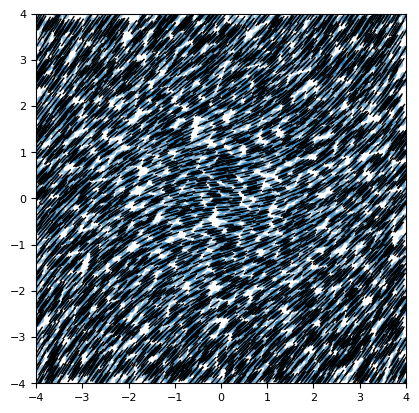

In [30]:
d = np.vectorize(lambda x, y: 1e-1)
a_real, a_imag = np.vectorize(lambda x, y: 1e-2), np.vectorize(lambda x, y: np.sqrt(x**2+y**2) * 3e-3)
a = np.vectorize(lambda x, y: a_real(x, y) + a_imag(x, y) * 1j)
c_real, c_imag = np.vectorize(lambda x, y: 1e-2), np.vectorize(lambda x, y: np.sqrt(x**2+y**2) * 3e-3)
c = np.vectorize(lambda x, y: c_real(x, y) + c_imag(x, y) * 1j)
s = np.vectorize(lambda x, y: 1e-2)

gammas = gamma(RAs, Decs)
e_s = np.abs(gammas*2)
phi_s = np.angle(gammas*2)
a_ep_s = np.sqrt(S(RAs, Decs))
b_ep_s = a_ep_s * np.sqrt(1 - e_s**2)
print(a_ep_s.shape, b_ep_s.shape, e_s.shape, phi_s.shape, np.degrees(phi_s).shape)

# Create tuples of the random RA and Dec values
rand_coords = np.vstack((RAs, Decs, a_ep_s, b_ep_s, phi_s, gammas)).T
print(rand_coords.shape)

fig, ax = plt.subplots()
# Loop over the RA and Dec values
for ra, de, a_ep, b_ep, phi, gam in rand_coords:
    ra, de, a_ep, b_ep, phi = np.real([ra, de, a_ep, b_ep, phi])
    # Create an ellipse patch with a given size centered at the RA, Dec position
    plt.plot(*getLineParameters(ra, de, gam), color="black", lw=1)
    ellipse = Ellipse(xy=(ra, de), width=a_ep, height=b_ep, angle=np.degrees(phi), alpha=0.5)
    # Add the ellipse patch to the axes
    ax.add_patch(ellipse)

# Show the plot
ax.set_aspect('equal')
plt.xlim(RA_range)
plt.ylim(Dec_range)
plt.show()

In [31]:
RA_grid, Dec_grid = np.meshgrid(np.linspace(*RA_range), np.linspace(*Dec_range))
coeffs = [d, a_real, a_imag, s, c_real, c_imag, \
         np.vectorize(lambda x, y : np.real(Q(x, y))), \
          np.vectorize(lambda x, y : np.imag(Q(x, y))), S]
labels = [r"$d$", r"$\Re(a)$", r"$\Im(a)$", r"$s$", r"$\Re(c)$", r"$\Im(c)$", \
          r"$\Re(Q)$", r"$\Im(Q)$", r"S"]

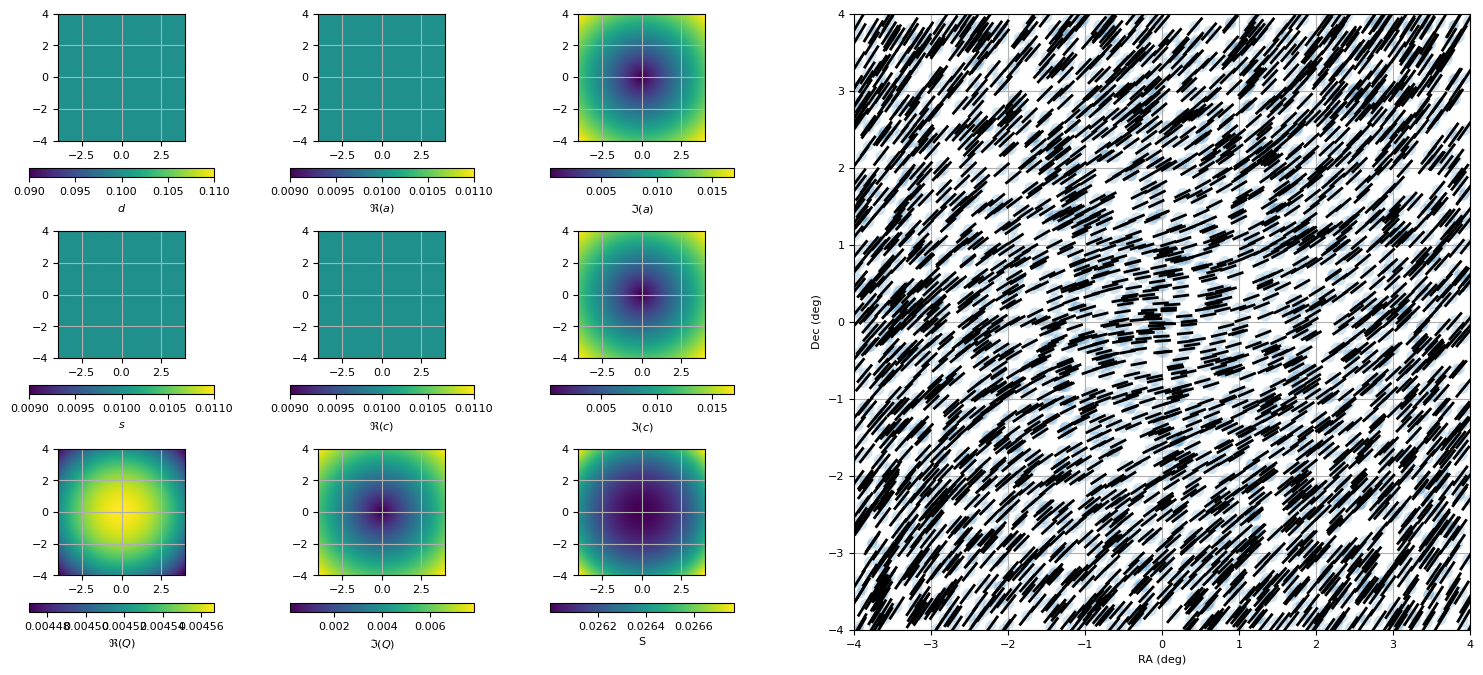

In [37]:
fig = plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 8})
gs = fig.add_gridspec(3, 24)
axs = list(map(fig.add_subplot, [gs[0, 4*y:4*y+3] for y in range(3)] + \
               [gs[1, 4*y:4*y+3] for y in range(3)] + [gs[2, 4*y:4*y+3] for y in range(3)]))
for ax, coeff, label in zip(axs, coeffs, labels):
    f = ax.imshow(coeff(RA_grid, Dec_grid), origin="lower", extent=[*RA_range, *Dec_range])
    cbar = fig.colorbar(f, orientation='horizontal')
    cbar.set_label(label)
    ax.set_aspect('equal')
    ax.grid()

ax = fig.add_subplot(gs[:, 11:])
for ra, de, a_ep, b_ep, phi, gam in rand_coords[::2]:
    ra, de, a_ep, b_ep, phi = np.real([ra, de, a_ep, b_ep, phi])
    # Create an ellipse patch with a given size centered at the RA, Dec position
    plt.plot(*getLineParameters(ra, de, gam), color="black", lw=2)
    ellipse = Ellipse(xy=(ra, de), width=a_ep, height=b_ep, angle=np.degrees(phi), alpha=0.2)
    # Add the ellipse patch to the axes
    ax.add_patch(ellipse)

# Show the plot
ax.set_aspect('equal')
ax.grid()
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
plt.xlim(RA_range)
plt.ylim(Dec_range)
plt.show()

In [33]:
axs

[<AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >]

In [9]:
[gs[0, 4*y:4*y+3] for y in range(3)] + [gs[1, 4*y:4*y+3] for y in range(3)]

[GridSpec(2, 24)[0:1, 0:3],
 GridSpec(2, 24)[0:1, 4:7],
 GridSpec(2, 24)[0:1, 8:11],
 GridSpec(2, 24)[1:2, 0:3],
 GridSpec(2, 24)[1:2, 4:7],
 GridSpec(2, 24)[1:2, 8:11]]